# Gaussian Process Regression Model 

Squared exponential kernel 

$
k(x_1, x_2) = \sigma^2 \exp{(-||x_2 - x_1||^2_2 / (2 \ell))}, 
$
where $\ell > 0$ is the lengthscale and $\sigma^2 > 0$ is variance.

Multivariate Normal distribution adoptation

$
\mathcal{N}(K_1 K^{-1} y, K_2 - K_1 K^{-1} K_1^\text{T}) + \sigma^2 I 
$



In [54]:
import numpy as np 

# plotting 
import matplotlib.pyplot as plt 
import seaborn as sns 
import seaborn_image as isns

# use tex fonts
sns.set(font_scale=1.5, rc={'text.usetex' : True})

# this will create thicker lines and larger fonts than usual
isns.set_context("notebook")

# change image related settings
isns.set_image(cmap="deep", despine=True)  # set the colormap and despine the axes
isns.set_scalebar(color="red")             # change scalebar color


### Code for Square Exponential Kernel (aka RBF) 


In [145]:
class SquareExponentialKernel:

    def __init__(self, sigma=1, ell=1):
        self.sigma = sigma 
        self.ell   = ell 
    
    def __call__(self, x1, x2):
        return self.sigma**2 * np.exp(-np.linalg.norm(x2 - x1)**2 / (2 * self.ell**2))
    
class GPR:

    def __init__(self, inp_x, inp_y, noise, covariance_function=SquareExponentialKernel()):
        self.inp_x = inp_x 
        self.inp_y = inp_y 
        self.covariance_function = covariance_function
        self.noise = noise
        self.buff  = None 
    
    def predict(self, ): 
        pass

### Understanding of the Gaussian process regression



Sample from univariate Gaussian Distribution 

$
P_X(x) = \dfrac{1}{\sqrt{2 \pi} \sigma} \exp\Big(-\dfrac{(x - \mu)^2}{2 \sigma^2}\Big)
$

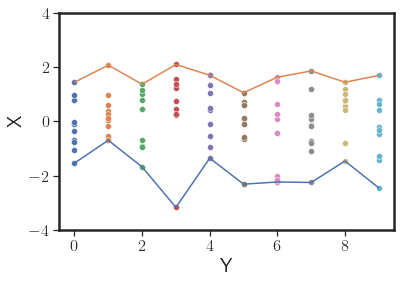

In [134]:
# sample x and y from normal distribution 
nvecs   = 10
samples = 10
curves  = []

sns.set_style("white")
sns.set_style("ticks")
for i in range(nvecs):
    # make gaussian vector 
    ys = np.random.normal(size=samples)
    xs = [i] * samples
    sns.scatterplot(x=xs, y=ys)
    curves.append([np.min(ys), np.max(ys)])

curves = np.array(curves)

for c in range(curves.shape[1]):
    sns.lineplot(x=list(range(nvecs)), y=curves[:, c])

plt.xlabel('Y')
plt.ylabel('X')
plt.ylim([-4,4])
plt.show()

Sample from the multivariate Gaussian Distribution for $D$-dimensional random vector, components of which are random variables $\vec{X} = (X_0, X_1, ..., X_D)^\text{T}$ reads 

$
N(\vec{\mu}, \Sigma) = \dfrac{1}{\sqrt{(2 \pi)^D |\Sigma| }} \exp\Big(-\dfrac{1}{2} (\vec{X} - \vec{\mu})^\text{T}\Sigma^{-1}(\vec{X} - \vec{\mu})\Big),
$
where $\vec{\mu} = (E[X_0], E[X_1], ..., E[X_D])$, $\Sigma_{i,j} = E[(X_i - \mu_i)(X_j - \mu_j)]$ 

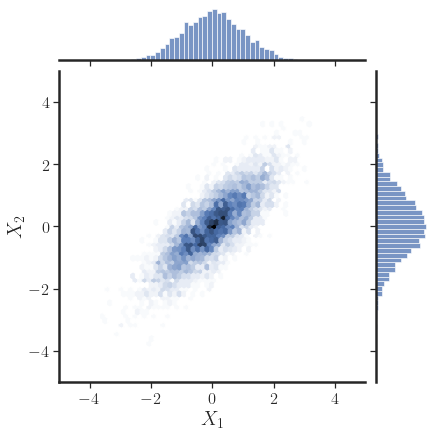

In [135]:
mean = [0, 0]
cov = [
        [1, 0.8], 
        [0.8, 1]
      ]

xmg, ymg = np.random.multivariate_normal(mean, cov, 5000).T

#fig, ax = plt.subplots(figsize=(6,6)) 
#sns.scatterplot(x=xmg, y=ymg)
sns.jointplot(
    x=xmg, y=ymg,
    kind="hex"
)

plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.show()

In [168]:
def plot_cov_matr(sigma, ell):
    # make covariance matrix
    rbf = SquareExponentialKernel(sigma=sigma, ell=ell)
    cov_mv = [[rbf(i, j) for i in np.arange(nvecs)] for j in np.arange(nvecs)]
    vars_lbls = [str(i) for i in range(nvecs)]
    # plot covariance matrix
    fig, ax = plt.subplots(figsize=(6,6)) 
    sns.heatmap(
        cov_mv,
        xticklabels=vars_lbls,
        yticklabels=vars_lbls,
        cmap="YlGnBu",
        annot=True, 
        ax=ax,
        fmt='.1f',
        cbar_kws={'label': 'Correlation'}
        )
    plt.title('Covariance matrix')
    plt.show()

In [180]:
interactive_plot_covmatr = interactive(plot_cov_matr, 
                                       sigma=(0.001, 2.1, 0.1), 
                                       ell=(0.001, 4.0, 0.25),
                                       )
output_covmatr = interactive_plot_covmatr.children[-1]
output_covmatr.layout.height = '400px'
interactive_plot_covmatr

interactive(children=(FloatSlider(value=1.001, description='sigma', max=2.1, min=0.001), FloatSlider(value=1.7…

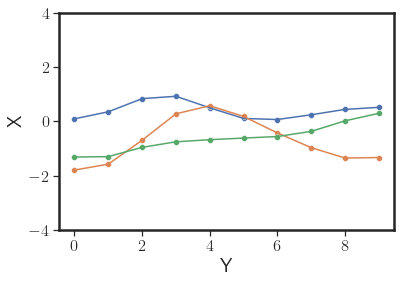

In [166]:
rbf = SquareExponentialKernel(sigma=1, ell=2)

cov_mv = [[rbf(i, j) for i in np.arange(nvecs)] for j in np.arange(nvecs)]
vars_lbls = [str(i) for i in range(nvecs)]

mean_mv = nvecs * [0]
ymv = np.random.multivariate_normal(mean_mv, cov_mv, 1000).T

# draw samples from the multivariate gaussian distribution
sns.set_style("white")
sns.set_style("ticks")

for i in range(3):
    sns.scatterplot(x=range(nvecs), y=ymv[:, i])
    sns.lineplot(x=range(nvecs), y=ymv[:, i])

plt.xlabel('Y')
plt.ylabel('X')
plt.ylim([-4,4])
plt.show()

In [164]:
import ipywidgets as widgets
from ipywidgets import interactive

In [165]:
def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot



interactive(children=(FloatSlider(value=0.0, description='m', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

In [10]:
k = SquareExponentialKernel(0.001, 0.001)


In [11]:
rng = np.arange(0,1,0.01)
M = np.array([[k(a,b) for a in rng] for b in rng])


Here


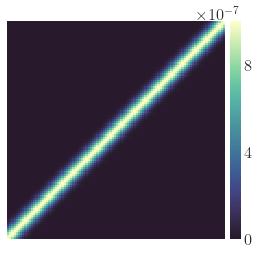

In [20]:
ax = isns.imgplot(M)
plt.savefig('imgs/t.png')
plt.show()

In [35]:
np.cov([[0, 1, 2], [0, 1, 2]])


array([[1., 1.],
       [1., 1.]])